# Notebook 2 - Model de Clustering amb K-Means

Aquest notebook aplica tècniques de clustering per segmentar jugadors de bàsquet en perfils esportius. Inclou:

- Càrrega de dades processades (datasets escalats i agregats)
- Selecció del nombre òptim de clústers (Elbow Method + Silhouette Score)
- Aplicació de K-Means i assignació de clústers
- Anàlisi de qualitat i estabilitat dels clústers
- Reducció dimensional amb PCA i interpretació de components
- Interpretació esportiva i assignació de noms als clústers

## 1. Imports i Càrrega de Dades

Importa les llibreries necessàries (pandas, numpy, matplotlib, seaborn, sklearn) i configura l'entorn de visualització. Carrega les eines de clustering (K-Means), mètriques d'avaluació (Silhouette Score) i reducció dimensional (PCA).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

Carrega els datasets processats (scaled, raw, aggregated) des dels fitxers CSV. Separa la informació identificativa dels jugadors de les features numèriques i crea la matriu X per al clustering.

In [2]:
# Carregar dades processades
df_scaled = pd.read_csv('../data/processed/players_features_scaled.csv')
df_raw = pd.read_csv('../data/processed/players_features_raw.csv')
df_agg = pd.read_csv('../data/processed/players_aggregated.csv')

print(f"Dades carregades")
print(f"  Scaled shape: {df_scaled.shape}")
print(f"  Raw shape: {df_raw.shape}")
print(f"  Aggregated shape: {df_agg.shape}")
print(f"  Jugadors: {len(df_scaled)}")

# Separar info dels jugadors i features
player_info = df_scaled[['player_feb_id', 'player_name']].copy()
feature_cols = [c for c in df_scaled.columns if c not in ['player_feb_id', 'player_name']]
X = df_scaled[feature_cols].values

print(f"  Features ({len(feature_cols)}): {feature_cols}")
print(f"  X shape: {X.shape}")

Dades carregades
  Scaled shape: (1816, 22)
  Raw shape: (1816, 20)
  Aggregated shape: (1816, 27)
  Jugadors: 1816
  Features (20): ['pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36', 'tov_per36', 'fga_per36', '3pa_per36', '2pa_per36', 'fg2_pct', 'fg3_pct', 'ft_pct', 'usage_2p', 'usage_3p', 'oer', 'der', 'true_shooting_pct', 'orb', 'drb', 'pf']
  X shape: (1816, 20)


## 2. Determinar Nombre Òptim de Clústers

Determina el nombre òptim de clústers utilitzant l'Elbow Method (inèrcia) i el Silhouette Score per diferents valors de k. Visualitza els resultats per seleccionar un k equilibrat que maximitzi la cohesió interna i la separació entre clústers.

### 2.1. Càlcul d'Inèrcia i Silhouette Score

Calcula la inèrcia i el Silhouette Score per un rang de valors de k (2 a 14). Per cada k, entrena un model K-Means i emmagatzema les mètriques per visualització posterior.

In [3]:
# Calcular inèrcia per diferents k
import warnings
import sys
import os
warnings.filterwarnings('ignore')

inertias = []
silhouette_scores = []
K_range = range(2, 15)

# Suprimir tot l'output durant el càlcul
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        return self
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

with SuppressOutput():
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Mostrar resum
print("\nResum dels resultats:")
print(f"{'K':<4} {'Inertia':>12} {'Silhouette':>12}")
print("-" * 30)
for k, inertia, sil in zip(K_range, inertias, silhouette_scores):
    print(f"{k:<4} {inertia:>12.2f} {sil:>12.3f}")


Resum dels resultats:
K         Inertia   Silhouette
------------------------------
2        28414.81        0.192
3        24130.81        0.179
4        22388.86        0.133
5        20816.69        0.135
6        19902.93        0.126
7        19136.47        0.119
8        18611.85        0.107
9        18183.47        0.102
10       17716.79        0.099
11       17335.17        0.100
12       17029.10        0.097
13       16765.69        0.094
14       16522.10        0.090


Visualitza els resultats de l'Elbow Method (inèrcia) i els Silhouette Scores per identificar el nombre òptim de clústers. El punt on la inèrcia deixa de disminuir significativament indica el k adequat.

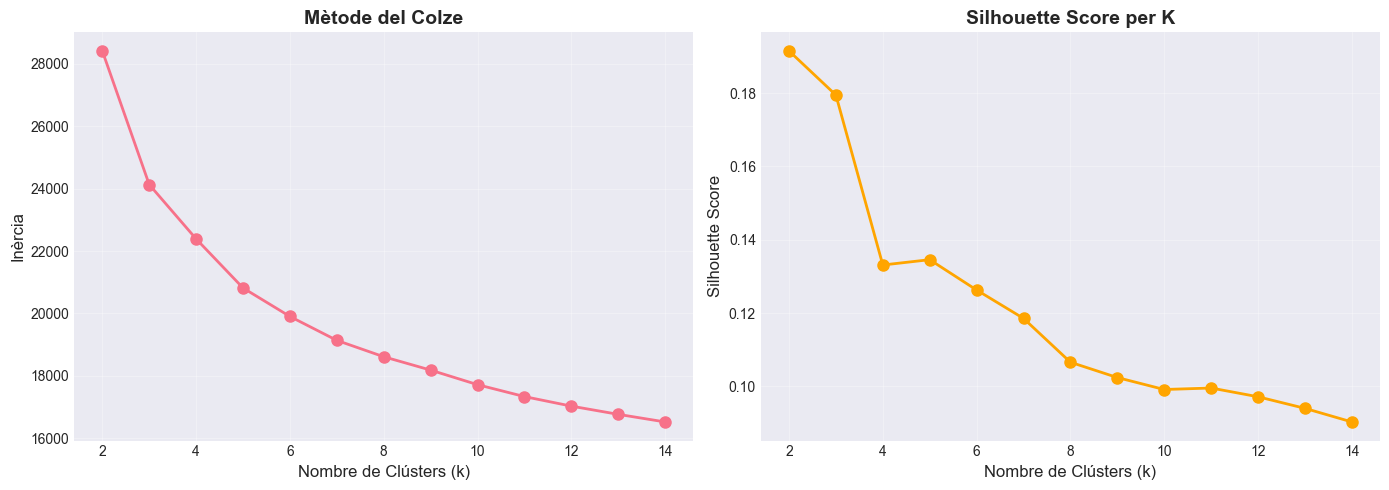

In [4]:
# Visualitzar mètode del colze
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Inèrcia
ax1.plot(K_range, inertias, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Nombre de Clústers (k)', fontsize=12)
ax1.set_ylabel('Inèrcia', fontsize=12)
ax1.set_title('Mètode del Colze', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Nombre de Clústers (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score per K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Aplicar K-Means

Aplica K-Means amb el nombre òptim de clústers (k=5) sobre les dades escalades. Calcula el Silhouette Score global per avaluar la qualitat de la separació entre clústers i assigna els clústers als jugadors.

In [5]:
# Escollir K òptim (ajustar segons els resultats)
OPTIMAL_K = 5  # MODIFICAR SEGONS NECESSITAT

# Entrenar model final
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X)

# Avaluar
silhouette_avg = silhouette_score(X, clusters)
print(f"\nModel K-Means entrenat amb k={OPTIMAL_K}")
print(f"Inèrcia: {kmeans_final.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Afegir clústers al DataFrame
df_raw['cluster'] = clusters
player_info['cluster'] = clusters


Model K-Means entrenat amb k=5
Inèrcia: 20816.64
Silhouette Score: 0.135


Afegeix les assignacions de clústers als DataFrames de jugadors (player_info i df_raw) per poder analitzar posteriorment els perfils de cada grup.

In [6]:
# Distribució de jugadors per clúster
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("\nDistribució de jugadors per clúster:")
for cluster_id, count in cluster_counts.items():
    print(f"  Clúster {cluster_id}: {count} jugadors ({count/len(clusters)*100:.1f}%)")


Distribució de jugadors per clúster:
  Clúster 0: 241 jugadors (13.3%)
  Clúster 1: 333 jugadors (18.3%)
  Clúster 2: 454 jugadors (25.0%)
  Clúster 3: 338 jugadors (18.6%)
  Clúster 4: 450 jugadors (24.8%)


### 3.1. Anàlisi Silhouette per Mostra

Calcula el coeficient Silhouette individual per a cada jugador i crea un gràfic horitzontal que mostra la qualitat de l'assignació de cada mostra dins del seu clúster. Identifica jugadors mal assignats (Silhouette < 0) i avalua la cohesió interna de cada clúster.

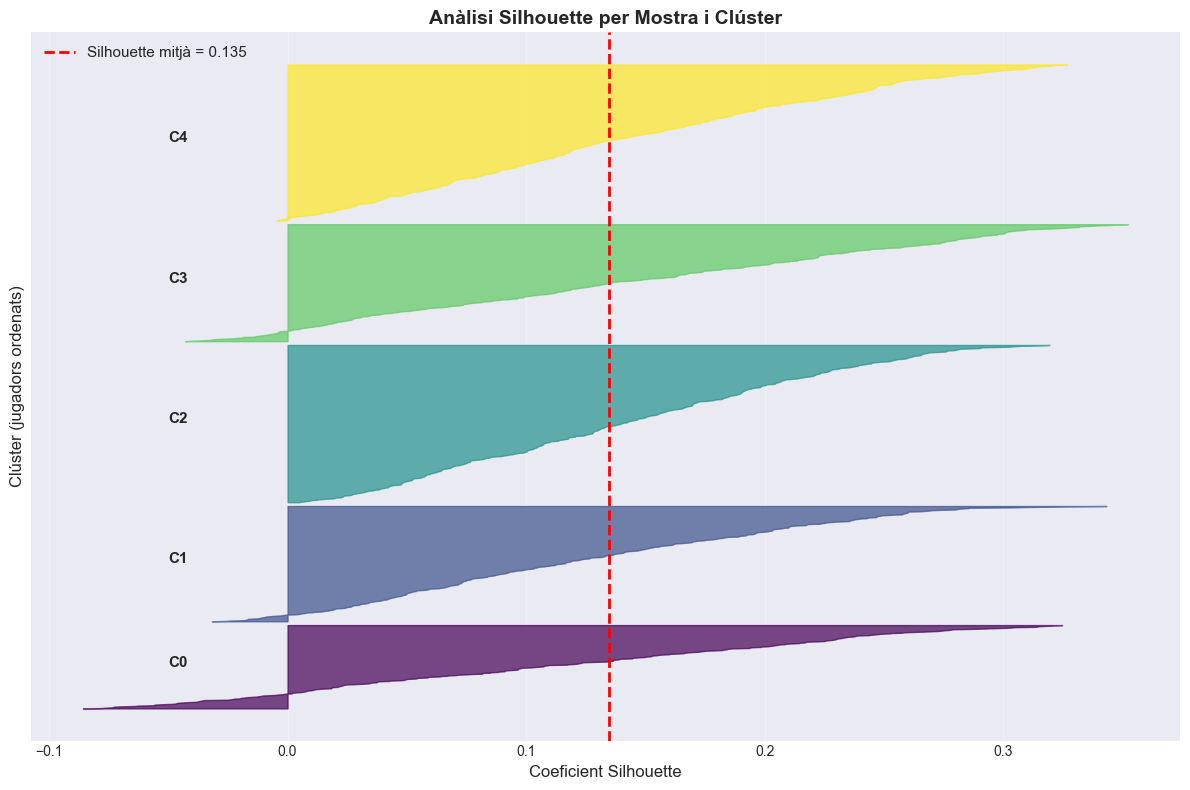


Silhouette per Clúster:
Clúster         N   Sil. Mitjà   Sil. Min   Sil. Max   % Negatius
--------------------------------------------------------------
C0            241        0.110     -0.086      0.325        17.8%
C1            333        0.123     -0.032      0.343         6.0%
C2            454        0.143      0.005      0.319         0.0%
C3            338        0.143     -0.043      0.352         8.9%
C4            450        0.142     -0.005      0.327         1.3%


In [7]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

sample_silhouette_values = silhouette_samples(X, clusters)

fig, ax = plt.subplots(figsize=(12, 8))
y_lower = 10

colors_sil = cm.get_cmap('viridis', OPTIMAL_K)

for i in range(OPTIMAL_K):
    # Valors silhouette del clúster i
    ith_cluster_values = sample_silhouette_values[clusters == i]
    ith_cluster_values.sort()
    
    size_cluster_i = ith_cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = colors_sil(i / OPTIMAL_K)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_values,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label al centre
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i}', fontsize=11, fontweight='bold')
    
    y_lower = y_upper + 10  # Espai entre clústers

# Línia vermella: silhouette global
ax.axvline(x=silhouette_avg, color='red', linestyle='--', linewidth=2,
           label=f'Silhouette mitjà = {silhouette_avg:.3f}')

ax.set_xlabel('Coeficient Silhouette', fontsize=12)
ax.set_ylabel('Clúster (jugadors ordenats)', fontsize=12)
ax.set_title('Anàlisi Silhouette per Mostra i Clúster', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../reports/figures/silhouette_per_sample.png', dpi=300, bbox_inches='tight')
plt.show()

# Resum numèric per clúster
print("\nSilhouette per Clúster:")
print(f"{'Clúster':<10} {'N':>6} {'Sil. Mitjà':>12} {'Sil. Min':>10} {'Sil. Max':>10} {'% Negatius':>12}")
print("-" * 62)
for i in range(OPTIMAL_K):
    vals = sample_silhouette_values[clusters == i]
    neg_pct = (vals < 0).sum() / len(vals) * 100
    print(f"C{i:<9} {len(vals):>6} {vals.mean():>12.3f} {vals.min():>10.3f} {vals.max():>10.3f} {neg_pct:>11.1f}%")

### 3.2. Validació d'Estabilitat dels Clústers

Valida l'estabilitat dels clústers executant K-Means 50 vegades amb diferents seeds aleatoris. Calcula el Silhouette Score i l'Adjusted Rand Index (ARI) per cada run per mesurar la consistència de les assignacions i detectar clústers inestables.

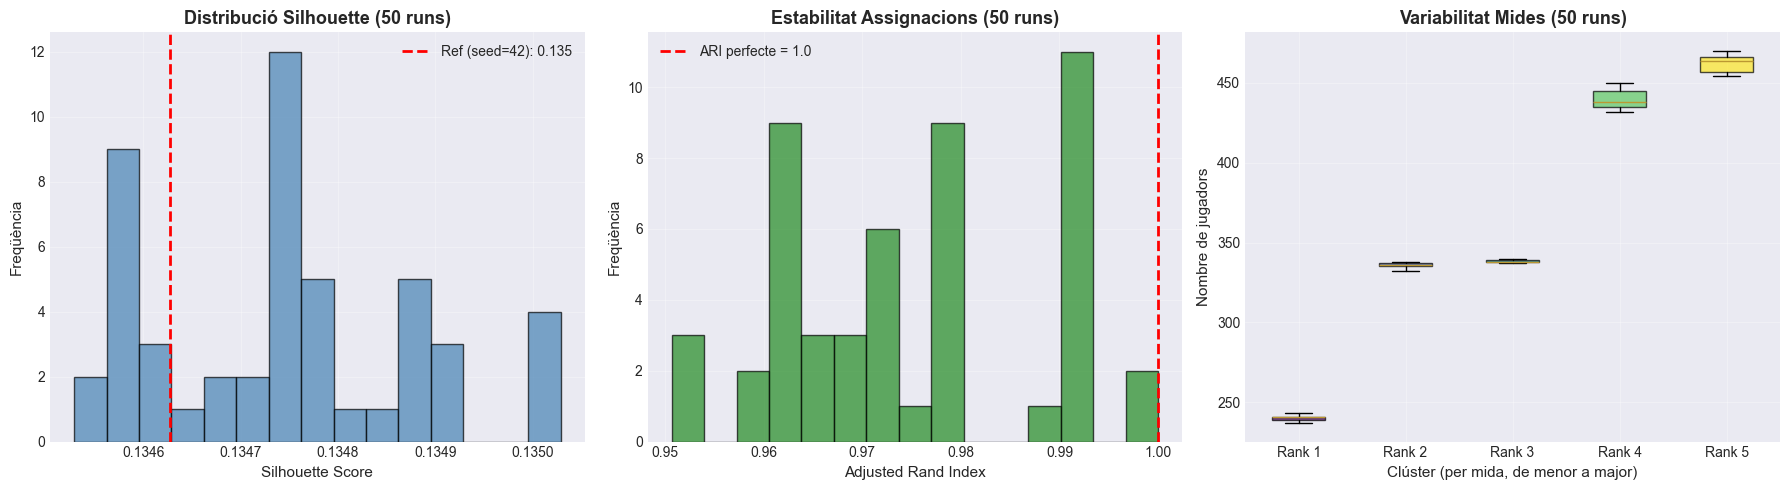


VALIDACIÓ D'ESTABILITAT (50 runs amb seeds 0..49)
  Silhouette: mitjà=0.1347, std=0.0001, rang=[0.1345, 0.1350]
  ARI vs ref: mitjà=0.9748, std=0.0127, rang=[0.9507, 1.0000]

  Silhouette MUY ESTABLE (std=0.0001)
  Assignacions PRÀCTICAMENT IDÈNTIQUES (ARI mitjà=0.9748)


In [8]:
from sklearn.metrics import adjusted_rand_score

N_RUNS = 50
reference_labels = clusters  # Assignació de referència (seed=42)

sil_scores_stability = []
ari_scores = []
cluster_sizes_all = []

for seed in range(N_RUNS):
    km = KMeans(n_clusters=OPTIMAL_K, random_state=seed, n_init=20)
    labels_run = km.fit_predict(X)
    
    sil_run = silhouette_score(X, labels_run)
    ari_run = adjusted_rand_score(reference_labels, labels_run)
    
    sil_scores_stability.append(sil_run)
    ari_scores.append(ari_run)
    
    sizes = pd.Series(labels_run).value_counts().sort_values().values
    cluster_sizes_all.append(sizes)

sil_scores_stability = np.array(sil_scores_stability)
ari_scores = np.array(ari_scores)

# --- Visualització ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribució Silhouette
axes[0].hist(sil_scores_stability, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(silhouette_avg, color='red', linestyle='--', linewidth=2, 
                label=f'Ref (seed=42): {silhouette_avg:.3f}')
axes[0].set_xlabel('Silhouette Score', fontsize=11)
axes[0].set_ylabel('Freqüència', fontsize=11)
axes[0].set_title(f'Distribució Silhouette ({N_RUNS} runs)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. Distribució ARI
axes[1].hist(ari_scores, bins=15, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='ARI perfecte = 1.0')
axes[1].set_xlabel('Adjusted Rand Index', fontsize=11)
axes[1].set_ylabel('Freqüència', fontsize=11)
axes[1].set_title(f'Estabilitat Assignacions ({N_RUNS} runs)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# 3. Variació de mides dels clústers
sizes_matrix = np.array(cluster_sizes_all)
bp = axes[2].boxplot([sizes_matrix[:, i] for i in range(OPTIMAL_K)],
                     labels=[f'Rank {i+1}' for i in range(OPTIMAL_K)],
                     patch_artist=True)
colors_bp = cm.get_cmap('viridis', OPTIMAL_K)
for patch, i in zip(bp['boxes'], range(OPTIMAL_K)):
    patch.set_facecolor(colors_bp(i / OPTIMAL_K))
    patch.set_alpha(0.7)
axes[2].set_xlabel('Clúster (per mida, de menor a major)', fontsize=11)
axes[2].set_ylabel('Nombre de jugadors', fontsize=11)
axes[2].set_title(f'Variabilitat Mides ({N_RUNS} runs)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/cluster_stability.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Resum numèric ---
print(f"\nVALIDACIÓ D'ESTABILITAT ({N_RUNS} runs amb seeds 0..{N_RUNS-1})")
print("=" * 55)
print(f"  Silhouette: mitjà={sil_scores_stability.mean():.4f}, "
      f"std={sil_scores_stability.std():.4f}, "
      f"rang=[{sil_scores_stability.min():.4f}, {sil_scores_stability.max():.4f}]")
print(f"  ARI vs ref: mitjà={ari_scores.mean():.4f}, "
      f"std={ari_scores.std():.4f}, "
      f"rang=[{ari_scores.min():.4f}, {ari_scores.max():.4f}]")

# Interpretació
if sil_scores_stability.std() < 0.005:
    sil_verdict = "Silhouette MUY ESTABLE"
elif sil_scores_stability.std() < 0.015:
    sil_verdict = "Silhouette ESTABLE"
else:
    sil_verdict = "Silhouette VARIABLE"

if ari_scores.mean() > 0.95:
    ari_verdict = "Assignacions PRÀCTICAMENT IDÈNTIQUES"
elif ari_scores.mean() > 0.80:
    ari_verdict = "Assignacions ESTABLES"
elif ari_scores.mean() > 0.60:
    ari_verdict = "Assignacions MODERADAMENT ESTABLES"
else:
    ari_verdict = "Assignacions INESTABLES"

print(f"\n  {sil_verdict} (std={sil_scores_stability.std():.4f})")
print(f"  {ari_verdict} (ARI mitjà={ari_scores.mean():.4f})")

### 3.3. Anàlisi PCA Complet

Aplica PCA complet sobre totes les features per analitzar la variància explicada per cada component principal. Genera scree plot, calcula la variància acumulada (80%, 90%, 95%) i crea un heatmap de feature loadings per als primers 3 PCs per entendre quines variables contribueixen més a cada component.

ANÀLISI DE VARIANÇA EXPLICADA (PCA)

Total de components (features): 20

Components necessàries per retenir:
  • 80% de variança → 7 components
  • 90% de variança → 10 components
  • 95% de variança → 12 components

Variança per component (top 10):
  PC 1: 33.91% | acum:  33.9% | █████████████████████████████████
  PC 2: 20.30% | acum:  54.2% | ████████████████████
  PC 3:  8.85% | acum:  63.1% | ████████
  PC 4:  6.03% | acum:  69.1% | ██████
  PC 5:  5.61% | acum:  74.7% | █████
  PC 6:  5.19% | acum:  79.9% | █████
  PC 7:  3.76% | acum:  83.7% | ███
  PC 8:  3.20% | acum:  86.9% | ███
  PC 9:  2.93% | acum:  89.8% | ██
  PC10:  2.39% | acum:  92.2% | ██


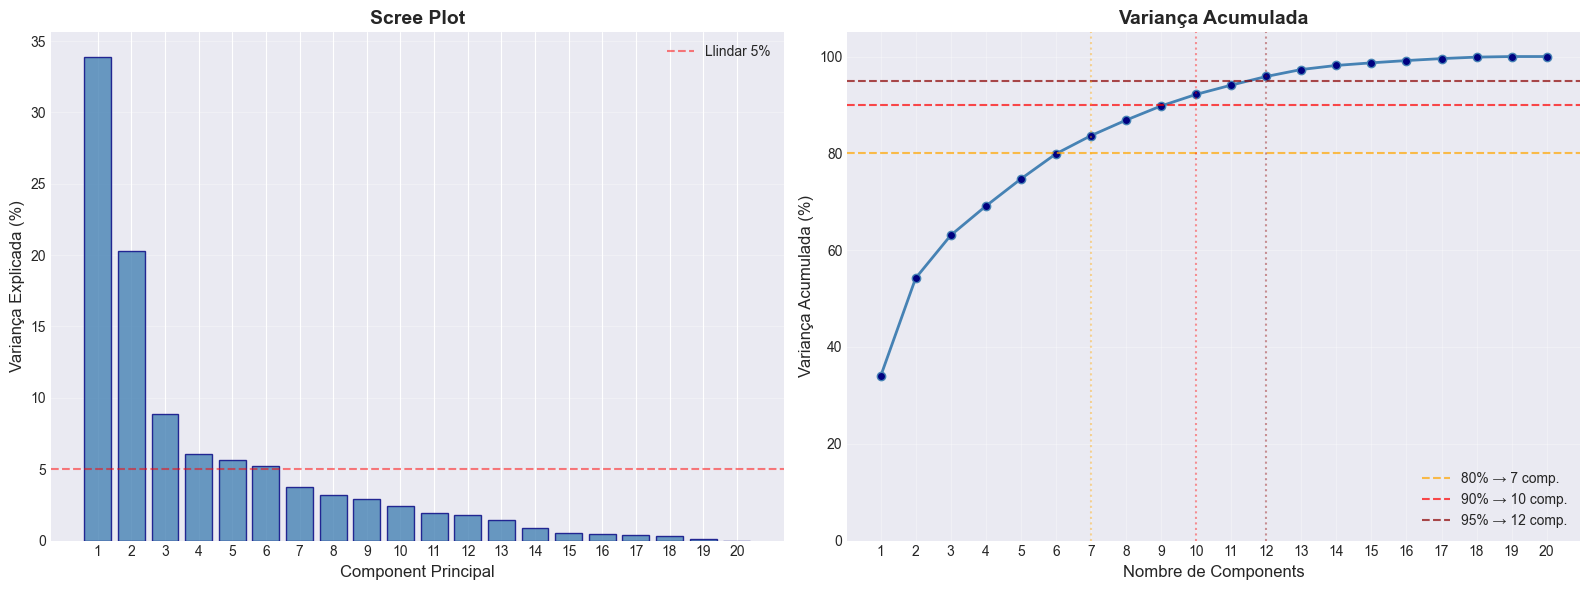


FEATURE LOADINGS (contribució de cada feature als PCs)

PC1 (variança: 33.91%) — Top 5 features:
  + 2pa_per36                : +0.3211
  + orb                      : +0.3147
  + usage_2p                 : +0.3094
  + trb_per36                : +0.2974
  + drb                      : +0.2953

PC2 (variança: 20.30%) — Top 5 features:
  + fg3_pct                  : +0.4108
  + 3pa_per36                : +0.4069
  + fga_per36                : +0.3574
  + usage_3p                 : +0.3397
  + pts_per36                : +0.3393

PC3 (variança: 8.85%) — Top 5 features:
  + tov_per36                : +0.5225
  + ast_per36                : +0.4562
  + stl_per36                : +0.3784
  - oer                      : -0.3386
  - true_shooting_pct        : -0.1840


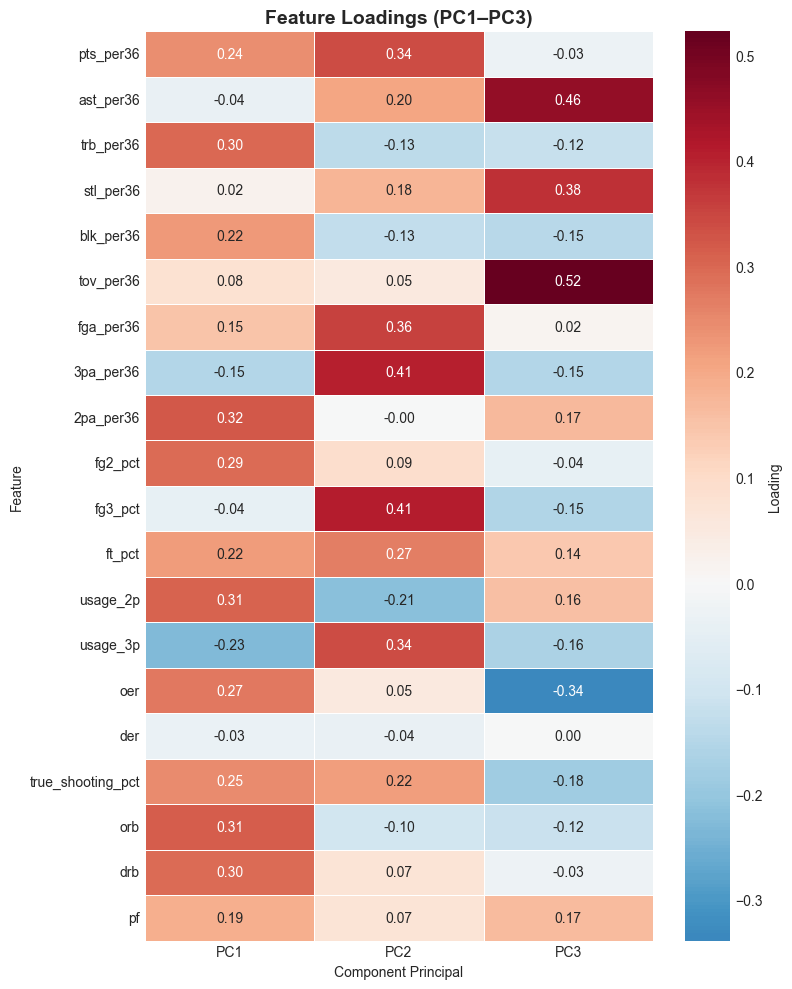


Conclusió: Amb 2 PCs retenim 54.2% de variança.
   La projecció 2D és adequada per visualització,
   però 7 components capturen 80% de la variança total.


In [9]:
import os
from pathlib import Path

FIGURES_DIR = Path(__file__).parent.parent / 'reports' / 'figures' if '__file__' in dir() else Path('..') / 'reports' / 'figures'
FIGURES_DIR = Path(os.path.abspath(FIGURES_DIR))
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

pca_full = PCA()
pca_full.fit(X)

explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)

# Trobar components necessàries per a 80%, 90%, 95%
n_80 = np.argmax(cumulative >= 0.80) + 1
n_90 = np.argmax(cumulative >= 0.90) + 1
n_95 = np.argmax(cumulative >= 0.95) + 1

print("=" * 60)
print("ANÀLISI DE VARIANÇA EXPLICADA (PCA)")
print("=" * 60)
print(f"\nTotal de components (features): {len(explained)}")
print(f"\nComponents necessàries per retenir:")
print(f"  • 80% de variança → {n_80} components")
print(f"  • 90% de variança → {n_90} components")
print(f"  • 95% de variança → {n_95} components")
print(f"\nVariança per component (top 10):")
for i in range(min(10, len(explained))):
    bar = "█" * int(explained[i] * 100)
    print(f"  PC{i+1:2d}: {explained[i]*100:5.2f}% | acum: {cumulative[i]*100:5.1f}% | {bar}")

# --- Figura: Scree plot + Variança acumulada ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].bar(range(1, len(explained)+1), explained * 100, color='steelblue', alpha=0.8, edgecolor='navy')
axes[0].set_xlabel('Component Principal', fontsize=12)
axes[0].set_ylabel('Variança Explicada (%)', fontsize=12)
axes[0].set_title('Scree Plot', fontsize=14, fontweight='bold')
axes[0].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Llindar 5%')
axes[0].legend()
axes[0].set_xticks(range(1, len(explained)+1))
axes[0].grid(axis='y', alpha=0.3)

# Variança acumulada
axes[1].plot(range(1, len(cumulative)+1), cumulative * 100, 'o-', color='steelblue',
             markerfacecolor='navy', markersize=6, linewidth=2)
axes[1].axhline(y=80, color='orange', linestyle='--', alpha=0.7, label=f'80% → {n_80} comp.')
axes[1].axhline(y=90, color='red', linestyle='--', alpha=0.7, label=f'90% → {n_90} comp.')
axes[1].axhline(y=95, color='darkred', linestyle='--', alpha=0.7, label=f'95% → {n_95} comp.')
axes[1].axvline(x=n_80, color='orange', linestyle=':', alpha=0.4)
axes[1].axvline(x=n_90, color='red', linestyle=':', alpha=0.4)
axes[1].axvline(x=n_95, color='darkred', linestyle=':', alpha=0.4)
axes[1].set_xlabel('Nombre de Components', fontsize=12)
axes[1].set_ylabel('Variança Acumulada (%)', fontsize=12)
axes[1].set_title('Variança Acumulada', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].set_xticks(range(1, len(cumulative)+1))
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Feature Loadings per als primers 3 PCs ---
print("\n" + "=" * 60)
print("FEATURE LOADINGS (contribució de cada feature als PCs)")
print("=" * 60)

loadings = pd.DataFrame(
    pca_full.components_[:3].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_cols
)

for pc in ['PC1', 'PC2', 'PC3']:
    sorted_loads = loadings[pc].abs().sort_values(ascending=False)
    print(f"\n{pc} (variança: {explained[int(pc[2:])-1]*100:.2f}%) — Top 5 features:")
    for feat in sorted_loads.index[:5]:
        val = loadings.loc[feat, pc]
        direction = "+" if val > 0 else "-"
        print(f"  {direction} {feat:25s}: {val:+.4f}")

# --- Heatmap de Loadings ---
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Loading'})
ax.set_title('Feature Loadings (PC1–PC3)', fontsize=14, fontweight='bold')
ax.set_ylabel('Feature')
ax.set_xlabel('Component Principal')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_loadings_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nConclusió: Amb 2 PCs retenim {cumulative[1]*100:.1f}% de variança.")
print(f"   La projecció 2D és {'adequada' if cumulative[1] > 0.40 else 'limitada'} per visualització,")
print(f"   però {n_80} components capturen 80% de la variança total.")

Redueix les dades a 2 dimensions utilitzant PCA per facilitar la visualització. Mostra la variància explicada per les dues primeres components principals (PC1 i PC2).

In [10]:
# Reduir a 2D amb PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"Variància explicada per les 2 components: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"  - PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  - PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

Variància explicada per les 2 components: 54.21%
  - PC1: 33.91%
  - PC2: 20.30%


Visualitza els jugadors projectats en 2D mitjançant PCA, amb colors segons el clúster assignat. Permet veure la distribució i separació dels clústers de manera intuïtiva.

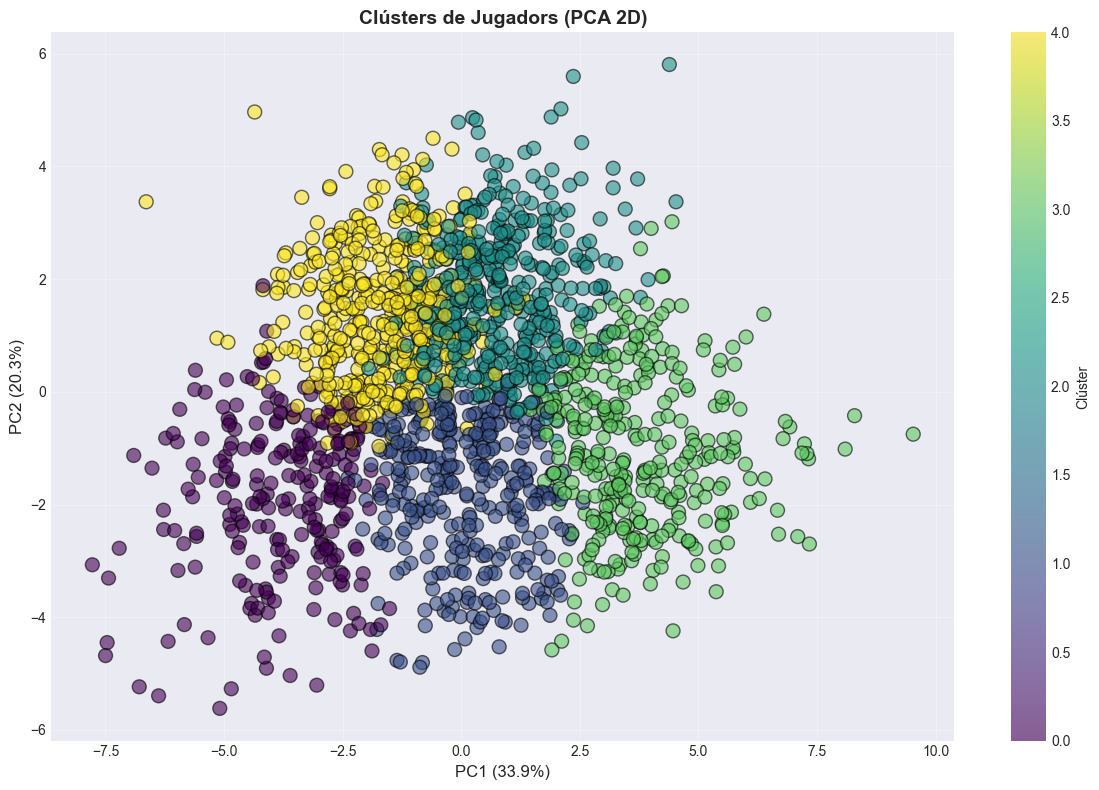

In [11]:
# Plot dels clústers
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black')
plt.colorbar(scatter, label='Clúster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.title('Clústers de Jugadors (PCA 2D)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Anàlisi i Interpretació dels Clústers

Calcula el perfil mitjà de cada clúster resumint les estadístiques dels jugadors per grup. Permet identificar característiques dominants (ofensiva, defensiva, tiradors, etc.) i comparar entre clústers.

In [12]:
# Estadístiques per clúster
cluster_profiles = df_raw.groupby('cluster').mean()
print("\nPerfil mitjà de cada clúster (primeres 10 features):")
print(cluster_profiles.iloc[:, :10].round(2))


Perfil mitjà de cada clúster (primeres 10 features):
         pts_per36  ast_per36  trb_per36  stl_per36  blk_per36  tov_per36  \
cluster                                                                     
0             5.51       2.15       4.08       1.19       0.08       2.55   
1             9.33       1.76       6.87       1.28       0.30       2.50   
2            16.10       3.27       5.93       1.95       0.22       3.13   
3            14.94       1.64      10.59       1.30       0.78       2.86   
4            12.31       2.37       4.70       1.41       0.14       2.21   

         fga_per36  3pa_per36  2pa_per36  fg2_pct  
cluster                                            
0             7.21       3.79       3.42     0.20  
1             8.73       2.03       6.70     0.43  
2            13.85       5.77       8.08     0.47  
3            11.86       1.78      10.08     0.52  
4            11.76       7.48       4.29     0.37  


Fa una interpretació esportiva dels clústers basada en desviacions percentuals respecte a la mitjana global. Classifica cada clúster amb traits com alta/baixa anotació, interior/exterior, creador, rebotejador, defensiu o eficient, proporcionant un perfil esportiu detallat.

In [13]:
# Analitzem les característiques de cada clúster i assignem noms esportius

# Calcular mitjanes globals per comparació
global_means = df_raw[feature_cols].mean()

# Perfils per clúster
cluster_profiles = df_raw.groupby('cluster')[feature_cols].mean()

# Funció per interpretar un clúster automàticament
def interpret_cluster(cluster_id, profile, global_means, n_players):
    """
    Interpreta un clúster basant-se en les desviacions de la mitjana global.
    Retorna un nom esportiu i una descripció.
    """
    # Calcular desviacions respecte la mitjana global (en %)
    deviations = ((profile - global_means) / global_means * 100).round(1)
    
    # Variables clau per la classificació
    pts = profile.get('pts_per36', 0)
    ast = profile.get('ast_per36', 0)
    trb = profile.get('trb_per36', 0)
    stl = profile.get('stl_per36', 0)
    blk = profile.get('blk_per36', 0)
    fg2 = profile.get('fg2_pct', 0)
    fg3 = profile.get('fg3_pct', 0)
    u2p = profile.get('usage_2p', 0)
    u3p = profile.get('usage_3p', 0)
    oer = profile.get('oer', 0)
    ts  = profile.get('true_shooting_pct', 0)
    
    # Lògica de classificació esportiva
    traits = []
    
    # Scoring
    if deviations.get('pts_per36', 0) > 20:
        traits.append('alta_anotacio')
    elif deviations.get('pts_per36', 0) < -20:
        traits.append('baixa_anotacio')
    
    # Perfil interior vs exterior  
    if deviations.get('usage_2p', 0) > 15 and deviations.get('usage_3p', 0) < -15:
        traits.append('interior')
    elif deviations.get('usage_3p', 0) > 15 and deviations.get('usage_2p', 0) < -15:
        traits.append('exterior')
    
    # Playmaking
    if deviations.get('ast_per36', 0) > 25:
        traits.append('creador')
    
    # Rebounding
    if deviations.get('trb_per36', 0) > 25:
        traits.append('rebotejador')
    
    # Defense
    if deviations.get('stl_per36', 0) > 20 or deviations.get('blk_per36', 0) > 30:
        traits.append('defensiu')
    
    # Efficiency
    if deviations.get('oer', 0) > 15 and deviations.get('true_shooting_pct', 0) > 10:
        traits.append('eficient')
    elif deviations.get('oer', 0) < -15:
        traits.append('ineficient')
    
    return traits, deviations


print("=" * 90)
print("ANÀLISI DETALLAT DELS CLÚSTERS")
print("=" * 90)

cluster_interpretations = {}

for cluster_id in sorted(df_raw['cluster'].unique()):
    n_players = cluster_counts[cluster_id]
    profile = cluster_profiles.loc[cluster_id]
    traits, deviations = interpret_cluster(cluster_id, profile, global_means, n_players)
    
    cluster_interpretations[cluster_id] = {
        'traits': traits,
        'deviations': deviations,
        'profile': profile,
        'n_players': n_players
    }
    
    print(f"\nCLÚSTER {cluster_id} ({n_players} jugadors, {n_players/len(df_raw)*100:.1f}%)")
    print("-" * 90)
    print(f"  Traits detectats: {traits}")
    print()
    
    # Estadístiques principals  
    print(f"  Ofensiva:")
    print(f"     Punts/36:    {profile['pts_per36']:6.1f}  (global: {global_means['pts_per36']:.1f}, {deviations['pts_per36']:+.1f}%)")
    print(f"     Assist/36:   {profile['ast_per36']:6.1f}  (global: {global_means['ast_per36']:.1f}, {deviations['ast_per36']:+.1f}%)")
    print(f"     OER:         {profile['oer']:6.1f}  (global: {global_means['oer']:.1f}, {deviations['oer']:+.1f}%)")
    print(f"     TS%:         {profile['true_shooting_pct']:6.3f}  (global: {global_means['true_shooting_pct']:.3f}, {deviations['true_shooting_pct']:+.1f}%)")
    
    print(f"  Tir:")
    print(f"     FG2%:        {profile['fg2_pct']*100:6.1f}%  (global: {global_means['fg2_pct']*100:.1f}%)")
    print(f"     FG3%:        {profile['fg3_pct']*100:6.1f}%  (global: {global_means['fg3_pct']*100:.1f}%)")
    print(f"     Ús 2P:       {profile['usage_2p']*100:6.1f}%  (global: {global_means['usage_2p']*100:.1f}%)")
    print(f"     Ús 3P:       {profile['usage_3p']*100:6.1f}%  (global: {global_means['usage_3p']*100:.1f}%)")
    
    print(f"  Altres:")
    print(f"     Rebots/36:   {profile['trb_per36']:6.1f}  (global: {global_means['trb_per36']:.1f}, {deviations['trb_per36']:+.1f}%)")
    print(f"     Robades/36:  {profile['stl_per36']:6.1f}  (global: {global_means['stl_per36']:.1f})")
    print(f"     Taps/36:     {profile['blk_per36']:6.1f}  (global: {global_means['blk_per36']:.1f})")
    print(f"     DER:         {profile['der']:6.1f}  (global: {global_means['der']:.1f})")
    
    # Top 5 jugadors
    cluster_players = player_info[player_info['cluster'] == cluster_id]
    sample = cluster_players.head(5)
    print(f"\n  Exemples: {', '.join(sample['player_name'].tolist())}")

ANÀLISI DETALLAT DELS CLÚSTERS

CLÚSTER 0 (241 jugadors, 13.3%)
------------------------------------------------------------------------------------------
  Traits detectats: ['baixa_anotacio', 'ineficient']

  Ofensiva:
     Punts/36:       5.5  (global: 12.3, -55.2%)
     Assist/36:      2.2  (global: 2.3, -7.1%)
     OER:           50.3  (global: 92.4, -45.6%)
     TS%:          0.276  (global: 0.460, -40.1%)
  Tir:
     FG2%:          19.5%  (global: 41.1%)
     FG3%:          11.5%  (global: 19.9%)
     Ús 2P:         36.5%  (global: 57.0%)
     Ús 3P:         41.8%  (global: 38.1%)
  Altres:
     Rebots/36:      4.1  (global: 6.4, -36.4%)
     Robades/36:     1.2  (global: 1.5)
     Taps/36:        0.1  (global: 0.3)
     DER:           96.4  (global: 94.7)

  Exemples: F. SERRA DE MUNTER, X. GUIA HORMIGON, C. CAÑELLAS FRADE, A. PUJADAS TARRADELLAS, D. DOMÍNGUEZ PORTAS

CLÚSTER 1 (333 jugadors, 18.3%)
-------------------------------------------------------------------------------

## 6. Assignar Noms als Clústers

Assigna noms esportius interpretatius als clústers basant-se en els traits detectats (ex: "Pivots Interiors", "Bases Creadors/Anotadors", "Tiradors Purs"). Genera descripcions automàtiques amb les estadístiques principals de cada grup.

In [14]:
# Basant-nos en l'anàlisi anterior, assignem noms esportius representatius.
# 
# IMPORTANT: Aquests noms s'han d'ajustar MANUALMENT després d'executar
# l'anàlisi anterior i interpretar les dades. Els noms per defecte es
# generen automàticament com a punt de partida.

def auto_name_cluster(traits, profile, global_means):
    """Genera un nom automàtic basat en els traits detectats."""
    
    # Determinar el perfil dominant
    if 'interior' in traits and 'rebotejador' in traits:
        return "Pivots Interiors"
    elif 'interior' in traits and 'alta_anotacio' in traits:
        return "Ala-Pivots Anotadors"
    elif 'interior' in traits:
        return "Jugadors Interiors"
    elif 'exterior' in traits and 'alta_anotacio' in traits:
        return "Tiradors Purs"
    elif 'exterior' in traits and 'creador' in traits:
        return "Bases Tiradors"
    elif 'exterior' in traits:
        return "Jugadors Exteriors"
    elif 'creador' in traits and 'alta_anotacio' in traits:
        return "Bases Creadors/Anotadors"
    elif 'creador' in traits:
        return "Bases Creadors de Joc"
    elif 'defensiu' in traits:
        return "Especialistes Defensius"
    elif 'ineficient' in traits and 'baixa_anotacio' in traits:
        return "Role Players Limitats"
    elif 'eficient' in traits:
        return "Jugadors Eficients"
    elif 'baixa_anotacio' in traits:
        return "Role Players"
    elif 'alta_anotacio' in traits:
        return "Anotadors Versàtils"
    else:
        return "Jugadors Versàtils"


# Generar noms automàtics
cluster_names = {}
cluster_descriptions = {}

for cluster_id, info in cluster_interpretations.items():
    name = auto_name_cluster(info['traits'], info['profile'], global_means)
    cluster_names[cluster_id] = name
    
    # Generar descripció esportiva
    p = info['profile']
    desc_lines = [f"  - {info['n_players']} jugadors ({info['n_players']/len(df_raw)*100:.1f}% del total)"]
    desc_lines.append(f"  - Mitjana de {p['pts_per36']:.1f} punts/36min, {p['ast_per36']:.1f} assist/36min, {p['trb_per36']:.1f} rebots/36min")
    desc_lines.append(f"  - Eficiència: OER={p['oer']:.1f}, TS%={p['true_shooting_pct']:.3f}")
    desc_lines.append(f"  - Perfil de tir: {p['usage_2p']*100:.0f}% ús 2P / {p['usage_3p']*100:.0f}% ús 3P")
    desc_lines.append(f"  - FG2%={p['fg2_pct']*100:.1f}%, FG3%={p['fg3_pct']*100:.1f}%")
    cluster_descriptions[cluster_id] = "\n".join(desc_lines)


# Assignar noms
df_raw['cluster_name'] = df_raw['cluster'].map(cluster_names)
player_info['cluster_name'] = player_info['cluster'].map(cluster_names)

print("NOMS ESPORTIUS ASSIGNATS ALS CLÚSTERS")
print("=" * 80)
for cluster_id in sorted(cluster_names.keys()):
    print(f"\nClúster {cluster_id}: «{cluster_names[cluster_id]}»")
    print(cluster_descriptions[cluster_id])

NOMS ESPORTIUS ASSIGNATS ALS CLÚSTERS

Clúster 0: «Role Players Limitats»
  - 241 jugadors (13.3% del total)
  - Mitjana de 5.5 punts/36min, 2.2 assist/36min, 4.1 rebots/36min
  - Eficiència: OER=50.3, TS%=0.276
  - Perfil de tir: 36% ús 2P / 42% ús 3P
  - FG2%=19.5%, FG3%=11.5%

Clúster 1: «Jugadors Interiors»
  - 333 jugadors (18.3% del total)
  - Mitjana de 9.3 punts/36min, 1.8 assist/36min, 6.9 rebots/36min
  - Eficiència: OER=94.6, TS%=0.444
  - Perfil de tir: 72% ús 2P / 21% ús 3P
  - FG2%=43.0%, FG3%=11.2%

Clúster 2: «Bases Creadors/Anotadors»
  - 454 jugadors (25.0% del total)
  - Mitjana de 16.1 punts/36min, 3.3 assist/36min, 5.9 rebots/36min
  - Eficiència: OER=92.5, TS%=0.502
  - Perfil de tir: 58% ús 2P / 42% ús 3P
  - FG2%=47.0%, FG3%=26.5%

Clúster 3: «Pivots Interiors»
  - 338 jugadors (18.6% del total)
  - Mitjana de 14.9 punts/36min, 1.6 assist/36min, 10.6 rebots/36min
  - Eficiència: OER=122.3, TS%=0.533
  - Perfil de tir: 85% ús 2P / 14% ús 3P
  - FG2%=52.1%, FG3%=1

## 7. Taula Resum per Clúster

Genera una taula resum amb les estadístiques clau (punts, assistències, rebots, percentatges de tir, OER, TS%, etc.) per a cada clúster. Guarda la taula com a CSV per a informes posteriors.

In [15]:
# Seleccionar estadístiques clau del basketball (només les que existeixin en df_raw)
desired_stats = [
    'pts_per36', 'ast_per36', 'trb_per36', 'stl_per36', 'blk_per36',
    'fg2_pct', 'fg3_pct', 'ft_pct', 'usage_2p', 'usage_3p',
    'oer', 'true_shooting_pct', 'der', 'possessions'
]
summary_stats = [s for s in desired_stats if s in df_raw.columns]

cluster_summary = df_raw.groupby('cluster_name')[summary_stats].mean().round(3)
cluster_summary.insert(0, 'num_players', df_raw.groupby('cluster_name').size())
cluster_summary = cluster_summary.sort_values('num_players', ascending=False)

# Mostrar taula
print("\nTAULA RESUM DELS CLÚSTERS")
print("=" * 120)
with pd.option_context('display.max_columns', None, 'display.width', 120):
    print(cluster_summary.to_string())
print("=" * 120)

# Guardar a CSV
import os
os.makedirs('../reports', exist_ok=True)
cluster_summary.to_csv('../reports/cluster_summary.csv')
print("\nTaula guardada a: ../reports/cluster_summary.csv")


TAULA RESUM DELS CLÚSTERS
                          num_players  pts_per36  ast_per36  trb_per36  stl_per36  blk_per36  fg2_pct  fg3_pct  ft_pct  usage_2p  usage_3p      oer  true_shooting_pct     der
cluster_name                                                                                                                                                                  
Bases Creadors/Anotadors          454     16.102      3.266      5.934      1.947      0.218    0.470    0.265   0.533     0.580     0.417   92.506              0.502  94.477
Jugadors Exteriors                450     12.313      2.369      4.701      1.411      0.142    0.370    0.291   0.318     0.354     0.629   90.628              0.476  94.200
Pivots Interiors                  338     14.944      1.639     10.591      1.301      0.783    0.521    0.133   0.457     0.847     0.143  122.348              0.533  93.695
Jugadors Interiors                333      9.332      1.760      6.865      1.280      0.301    0.

## 8. Guardar Resultats Finals

Guarda els dataframes amb clústers assignats i noms esportius als fitxers CSV (players_clustered.csv, player_clusters.csv) i la taula resum (cluster_summary.csv) per a ús posterior en visualitzacions i anàlisis.

In [16]:
# Guardar dades amb clústers assignats
df_raw.to_csv('../data/processed/players_clustered.csv', index=False)
player_info.to_csv('../data/processed/player_clusters.csv', index=False)

print("\nResultats guardats:")
print("  - ../data/processed/players_clustered.csv")
print("  - ../data/processed/player_clusters.csv")
print("  - ../reports/cluster_summary.csv")


Resultats guardats:
  - ../data/processed/players_clustered.csv
  - ../data/processed/player_clusters.csv
  - ../reports/cluster_summary.csv
